In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# Classifcation categories
fruits = ['peach', 'pomegranate', 'strawberry']
fruit_type = ['fresh', 'rotten']

# Set the image size
h, w = 50, 50

# Load the image data
data_set = [] # Image data
dataset_target = [] # Target information, [fresh/rotten, fruit type]

for fruit in fruits:
    for ft in fruit_type:
        # Open the directory
        path = f'./data/{ft}/{fruit}'

        # Load the image data
        # Reading the images in as numpy arrays in a list
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img))

            # Set color to RGB
            img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

            # Resize the image
            img_array = cv2.resize(img_array, (h, w))

            # Flatten the image
            img_array = img_array.flatten()
            data_set.append(img_array)

            # Add the target information
            dataset_target.append(list([ft, fruit]))


print(f'Loaded {len(data_set)} images')
print(f'{data_set[0].shape[0]} features per image')
print("Datatype of images: ", type(data_set[0]))

Loaded 1655 images
7500 features per image
Datatype of images:  <class 'numpy.ndarray'>


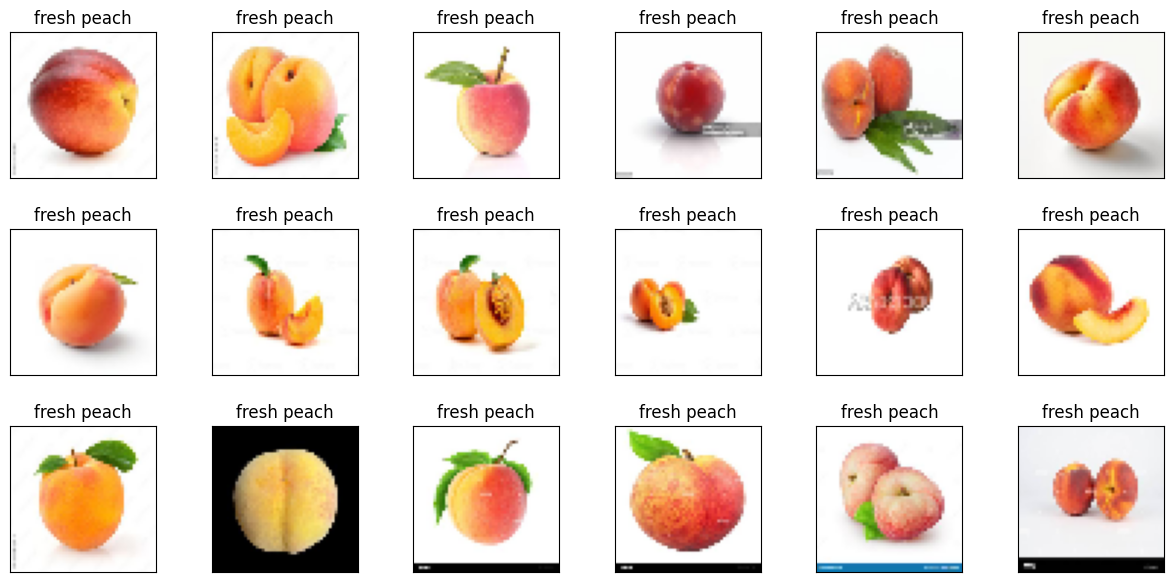

In [279]:
# Plotting sorted images based on fruit type
def plot_sorted_gallery(images, titles, h, w, n_row=3, n_col=6):
    plt.figure(figsize=(2 * n_col, 2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    
    # Sort indices based on fruit type
    sorted_indices = sorted(range(len(titles)), key=lambda k: titles[k][1])

    # Select a subset of sorted indices for plotting
    plot_index = sorted_indices[:n_row * n_col]

    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[plot_index[i]].reshape((h, w, 3)))
        title = titles[plot_index[i]][0] + " " + titles[plot_index[i]][1]
        plt.title(title, size=12)
        plt.xticks(())
        plt.yticks(())

# Use the updated function to plot sorted images
plot_sorted_gallery(data_set, dataset_target, h, w)
plt.show()

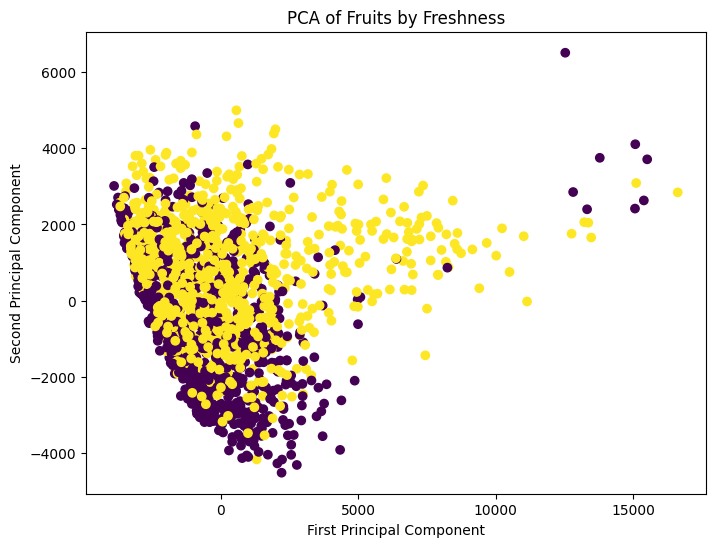

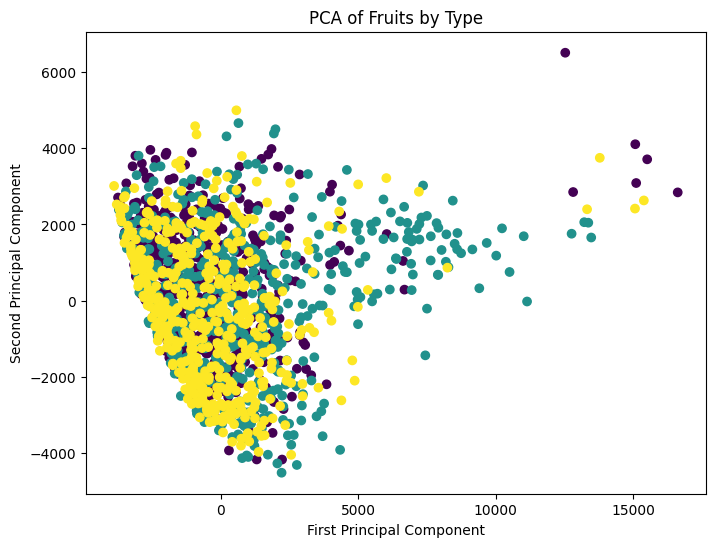

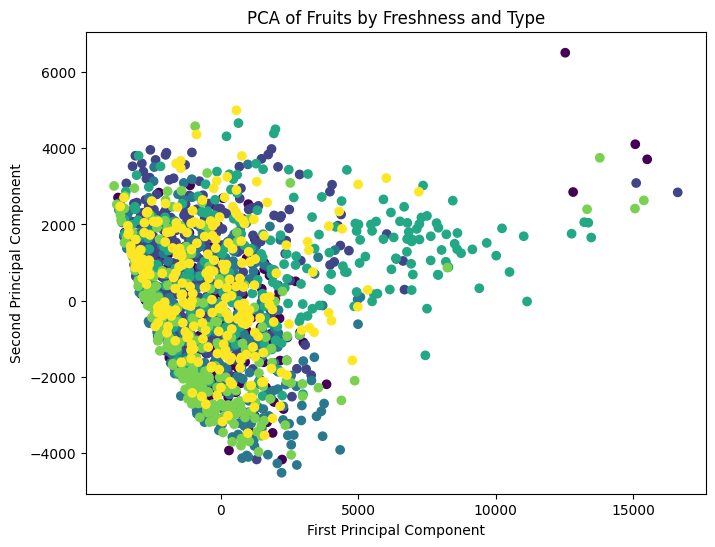

In [242]:
# PCA for dimensionality reduction
from sklearn.decomposition import PCA
 
# Perform PCA
pca = PCA(n_components=2)
data_set_pca = pca.fit_transform(data_set)

# Plot the PCA
plt.figure(figsize=(8, 6))  
plt.scatter(data_set_pca[:, 0], data_set_pca[:, 1], c=[0 if x[0] == 'fresh' else 1 for x in dataset_target])

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

plt.title('PCA of Fruits by Freshness')

plt.show()

# PCA of fruits by type
plt.figure(figsize=(8, 6))
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

plt.scatter(data_set_pca[:, 0], data_set_pca[:, 1], c=[0 if x[1] == 'peach' else 1 if x[1] == 'pomegranate' else 2 for x in dataset_target])

plt.title('PCA of Fruits by Type')

plt.show()

# PCA of fruits by freshness and type
plt.figure(figsize=(8, 6))
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

plt.scatter(data_set_pca[:, 0], 
            data_set_pca[:, 1],
            c=[0 if x[0] == 'fresh' and x[1] == 'peach' else 1 if x[0] == 'rotten' and x[1] == 'peach' else 2 if x[0] == 'fresh' and x[1] == 'pomegranate' else 3 if x[0] == 'rotten' and x[1] == 'pomegranate' else 4 if x[0] == 'fresh' and x[1] == 'strawberry' else 5 for x in dataset_target])

plt.title('PCA of Fruits by Freshness and Type')
plt.show()



We initially tried to use PCA to try to reduce the dimensionality of the the images by using only 2 dimensions. However, we found that the images were not well suited for 2 dimensional PCA. Plotted above are the graphs showing different coloring of the images based on the different classifications. We can see that the images are not well separated and that 2-dimensional PCA is not a good way to reduce the dimensionality of the images. This led us to try to increase the number of dimensions to 3 which is shown in the next section.

We can see a little bit of seperation between some of the classes but it is not enough to be useful for our purposes. Our next thought was to try to reduce the number of classes to see if that would help (for instance only comparing pomegranates and strawberries) which is shown in the next section.

As can be seen, we still were unable to get any useful information by using fewer classes. We then decided to try to use a different method to figure out exactly how many dimensions we should use to reduce the dimensionality of the images while still keeping the most information possible. We researched and found an article that suggested using the below method to determine the number of dimensions to use for PCA. We first plotted the cumulative explained variance ratio and outputted the number of dimensions needed to keep 85% of the variance.

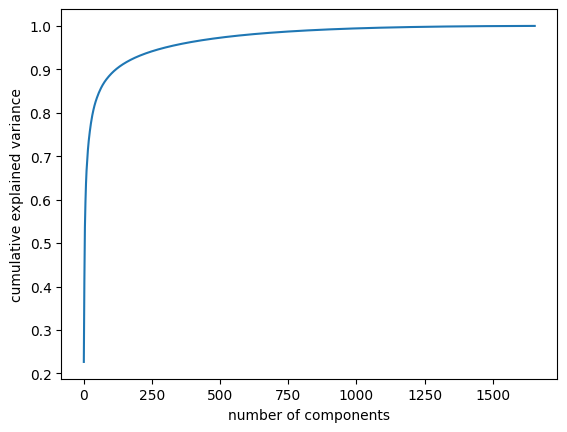

Number of components to explain 85% of the variance: 59


In [266]:
# Determine the number of components to use
# Source: https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html
pca = PCA().fit(data_set)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

plt.show()

# Get the number of components that explain 85% of the variance
pca = PCA(0.85)
pca.fit(data_set)
print(f'Number of components to explain 85% of the variance: {pca.n_components_}')

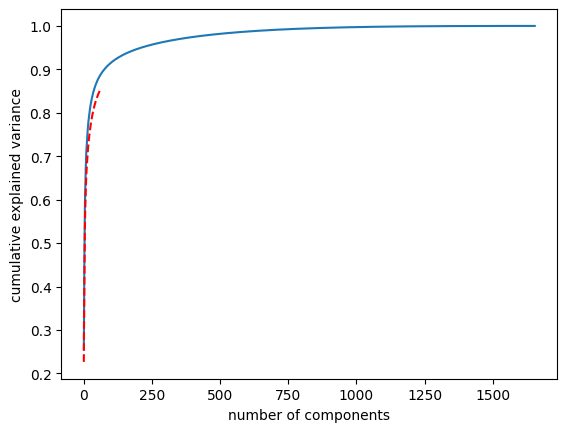

Number of components to explain 85% of the variance: 37


In [271]:
# Covert images to grayscale
data_set_gray = [cv2.cvtColor(x.reshape((h, w, 3)), cv2.COLOR_RGB2GRAY).flatten() for x in data_set]

# Compare the number of components to use
pca_grayscale = PCA().fit(data_set_gray)
plt.plot(np.cumsum(pca_grayscale.explained_variance_ratio_))
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'r', linestyle='--')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

plt.show()

# Get the number of components that explain 80% of the variance
pca_grayscale = PCA(0.85)
pca_grayscale.fit(data_set_gray)
print(f'Number of components to explain 85% of the variance: {pca_grayscale.n_components_}')



# Randomized PCA

## Feature Extraction using DAISY

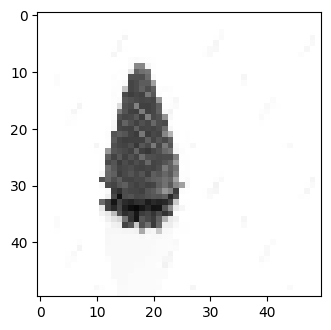

In [273]:
from skimage.io import imshow
import random as random

#Plotting code partially derived from Dr. Larson's GitHub https://github.com/eclarson/MachineLearningNotebooks/blob/master/04.%20Dimension%20Reduction%20and%20Images.ipynb
#Selecting an image to visualize the DAISY descriptor 
plt.subplot(1,2,1)
#Randomly choosing image to plot
idx_to_reconstruct = random.randint(0, len(data_set_gray))
img  = data_set_gray[idx_to_reconstruct].reshape(50,50)
plt.subplot(1,2,1)
imshow(img)
plt.grid(False)

We will be applying the DAISY function to images like the above. Below, we will visualize the DAISY descriptors of the image above.

Here, we are visualizing the application of the DAISY function onto the image selected from above. Now, we are going to apply the DAISY function to all of the images to extract features from the images. First, we will attempt to find the image closest matching the one selected using the DAISY features that we extracted. This will give us an idea of how well the DAISY function will perform on our data. Then we will attempt to measure how accurate the DAISY function is at classifying fruit type and freshness by running a k-nearest-neighbor multi-class multi-output classifier on the DAISY-applied data set.

In [275]:
from sklearn.metrics.pairwise import pairwise_distances
import copy

#Function partly derived from Dr. Larson's Github https://github.com/eclarson/MachineLearningNotebooks/blob/master/04.%20Dimension%20Reduction%20and%20Images.ipynb
def find_closest_image(data_set_gray, dataset_target, daisy_features, idx_to_reconstruct):
    #Minimizing pairwise distances between daisy features to find closest image to the selected image
    dist_matrix = pairwise_distances(daisy_features)
    idx1 = idx_to_reconstruct
    distances = copy.deepcopy(dist_matrix[idx1,:])
    distances[idx1] = np.infty 
    idx2 = np.argmin(distances)

    plt.figure(figsize=(7,10))
    plt.subplot(1,2,1)
    imshow(data_set_gray[idx1].reshape((h,w)))
    label1 = " ".join(dataset_target[idx1])
    plt.title("Original Image: "+ label1)
    plt.grid()

    plt.subplot(1,2,2)
    imshow(data_set_gray[idx2].reshape((h,w)))
    label2 = " ".join(dataset_target[idx2])
    plt.title("Closest Image: " + label2)
    plt.grid()

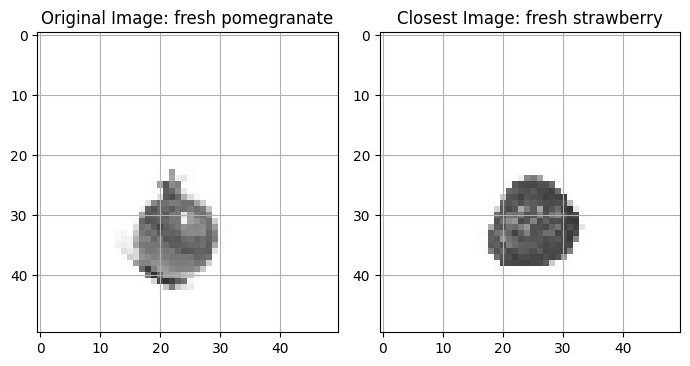

In [278]:
idx_to_reconstruct = random.randint(0, len(data_set_gray))

find_closest_image(data_set_gray, dataset_target, daisy_features, idx_to_reconstruct)

While the DAISY function struggles to consistently match a correct label, it does capture the general shape quite accurately. In all of our visualizations, the matched fruit is located roughly in same grid as the originally selected fruit. Therefore, DAISY seems to be quite effective at matching the position of extracted features, at the very least. However, with poor label matching, particularly of the fruit freshness, in a business setting where it is important to determine if fruit has gone rotten, DAISY will likely not be the most effective choice at classifying fruits. We would be better off using a different feature extraction method. In our k-nearest-neigbor classifier, we will be testing to see that our hypothesis of DAISY being a poor method of feature extraction for our dataset is correct

The results confirm our suspicion that DAISY is not the best method in order to classify our fruit type and freshness. With a consistent multi-class multi-output classifier score of about 40%, our accuracy is too low to ever justify the use of DAISY in a setting where an incorrect classification can get someone sick (by eating a rotten fruit). 

## Key Point Matching 

In [269]:
#Code partially derived from Dr. Larson's GitHub https://github.com/eclarson/MachineLearningNotebooks/blob/master/04.%20Dimension%20Reduction%20and%20Images.ipynb
def closest_match(source_img, source_idx, images, img_size):
    matched_idx = 0
    num_matches = 0
    #apply DAISY to image given
    source_daisy = apply_daisy(source_img, img_size)

    #Iterating through all other images to find the most similar image
    for i, img in enumerate(images):
        #Uses the index to prevent us from returning the original image as the 'most similar' iamge
        if i==source_idx:
            continue
        #apply DAISY to new image
        new_daisy = apply_daisy(img, img_size)

        #Key point matching on new DAISY-extracted image with original DAISY-extracted image
        matches = match_descriptors(source_daisy, new_daisy, cross_check=True, max_ratio=0.8)

        #if new image has more descriptor matches, set new image as best match to current image 
        if len(matches) > num_matches:
            num_matches = len(matches)
            matched_idx = i
    #Returns index of matched image
    #We will use this index to check if the labels match the source image's labels later
    return matched_idx


CPU times: total: 0 ns
Wall time: 0 ns


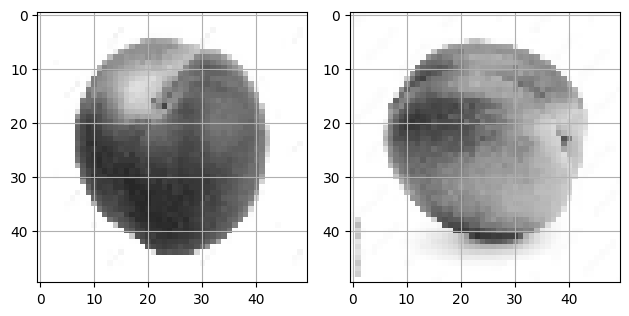

In [270]:
%time

#Visualizing our function by plotting the first value and its most similar image in the dataset
#This is where we use the index that we returned from the function above
matched_index = closest_match(data_set_gray[0], 0, data_set_gray, (h,w))
matched_image = data_set_gray[matched_index].reshape(50,50)
plt.subplot(1,2,1)
imshow(matched_image)
plt.grid()

plt.subplot(1,2,2)
imshow(data_set_gray[0].reshape(50,50))
plt.grid()

In [226]:
%time

#Keeps track of the correctly predicted values
preds = 0
#Length of the data. we will divide the correctly predicted values by this
count = len(data_set_gray)

#Iterating through each image in the data 
#This brute force matches each image with every other possible image in the data
#This will be incredibly time intensive...
for i in range(0, len(data_set_gray)):
    source_img = data_set_gray[i]

    matched_idx = closest_match(source_img, i, data_set_gray, (h,w))

    #If the label of the match is the same as the source image, add a value to the preds int
    #This keeps track of the correctly predicted values
    if dataset_target[matched_idx] == dataset_target[i]:
        preds += 1

CPU times: total: 0 ns
Wall time: 0 ns


KeyboardInterrupt: 

In [ ]:
# Manually calculating our accuracy by divided the correctly predicted labels by the total amount of labels.
accuracy = preds/count
print("Accuracy of key point matching of DAISY descriptors:", accuracy)

Accuracy of key point matching of DAISY descriptors: 0.4205438066465257


# Sources
- https://www.kaggle.com/datasets/alihasnainch/fruits-dataset-for-classification
- https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html